# Jellium
[?](?)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas 

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


### Set Parameters in Paper and Plot

In [48]:
name = 'Jellium'
Z, A = 1,1 

Te_eV = 1 # eV
rs_AU = 1
rs_cm = rs_AU/cm_to_AU
ne_cc = n_from_rs(rs_cm)
ne_AU = n_from_rs(rs_AU)


#### Run Ornstein-Zernike Closure

In [51]:
P_hnc_to_bar = lambda P_hnc: (P_hnc/rs_AU**3) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
E_hnc_to_eV   = lambda E_hnc: E_hnc/jellium.hnc.rho[0] * AU_to_eV

def get_jellium_P_Mbar(jellium_hnc):
    # jellium_hnc.h_r_matrix -= 1
    P_hnc = jellium_hnc.excess_pressure_matrix()
    # jellium_hnc.h_r_matrix += 1
    return P_hnc_to_Mbar(P_hnc)[0,0]


In [10]:
jellium = lambda Te_eV, ne_cc: PLASMA(1, 1, ne_cc, 1, Te_eV, Zbar=1, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

# Make Jellium PLASMA object
jellium = jellium_func(Te_eV, ne_cc)
jellium.run_jellium_hnc()
# Reset βvee
βvee_Pauli   = jellium.qsp.βv_Pauli(  jellium.jellium_hnc.r_array , jellium.qsp.Λee )
βvee_Pauli   = jellium.βP_ee
βvee_Deutsch = jellium.qsp.βv_Deutsch( jellium.qsp.Γee, jellium.jellium_hnc.r_array , jellium.qsp.Λee )
jellium.jellium_hnc.set_βu_matrix(np.array([[βvee_Pauli + βvee_Deutsch ]]))
jellium.jellium_hnc.HNC_solve(**jellium.hnc_solve_options)



Te_in_eV: 1.000
Ti_in_eV: 1.000


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:193: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 9.851e-02
Exiting status 0, reverting to best index so far: 35
Final iter:36, Total Error: 9.637e-09
0: Initial condition Total Error: 8.061e-03
Exiting status 0, reverting to best index so far: 28
Final iter:29, Total Error: 9.504e-09


0

#### Pressures

In [5]:
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))
jellium.jellium_hnc.βu_r_matrix[0,0] -= jellium.βP_ee
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))
jellium.jellium_hnc.βu_r_matrix[0,0] += jellium.βP_ee
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))

[[7445.35034754]]
[[6980.39304647]]
[[7445.35034754]]


In [36]:
P_Fermi_Mbar = 2/5 * jellium.qsp.E_F/(4/3*π*(jellium.qsp.ri)**3) * AU_to_bar/1e6

P_hnc_to_Mbar(jellium.jellium_hnc.ideal_pressure()),get_jellium_P_Mbar( jellium.jellium_hnc), P_Fermi_Mbar

(51.823981402874175, 7445.350347542549, 51.739302540025804)

##### Plot Radial Dsitribution Function

Missing colon in file '~/plasma/hnc/hnc_paper.mplstyle', line 40 ("text.latex.preamble = r'\\boldmath'")


(0.0, 5.0)

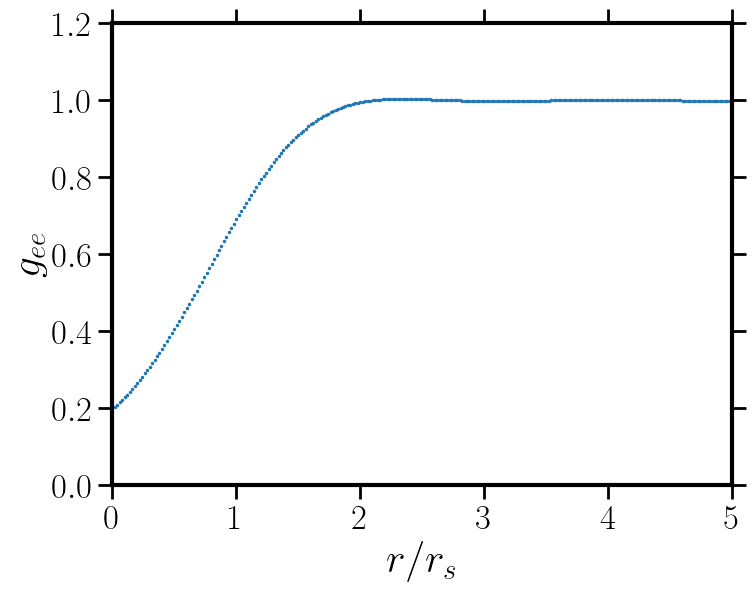

In [7]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

fig, ax = plt.subplots()

ax.plot(jellium.jellium_hnc.r_array, jellium.jellium_hnc.h_r_matrix[0,0]+1,'.', label='Default Pauli')
# ax.plot(jellium.jellium_hnc.r_array, jellium.jellium_hnc.h_r_matrix[0,0]+1, label='Default Pauli')


ax.set_xlabel(r"$r/r_s$")
ax.set_ylabel(r"$g_{ee}$")

ax.set_ylim(0,1.2)
ax.set_xlim(0,5)

#### Plot βu

Missing colon in file '~/plasma/hnc/hnc_paper.mplstyle', line 40 ("text.latex.preamble = r'\\boldmath'")


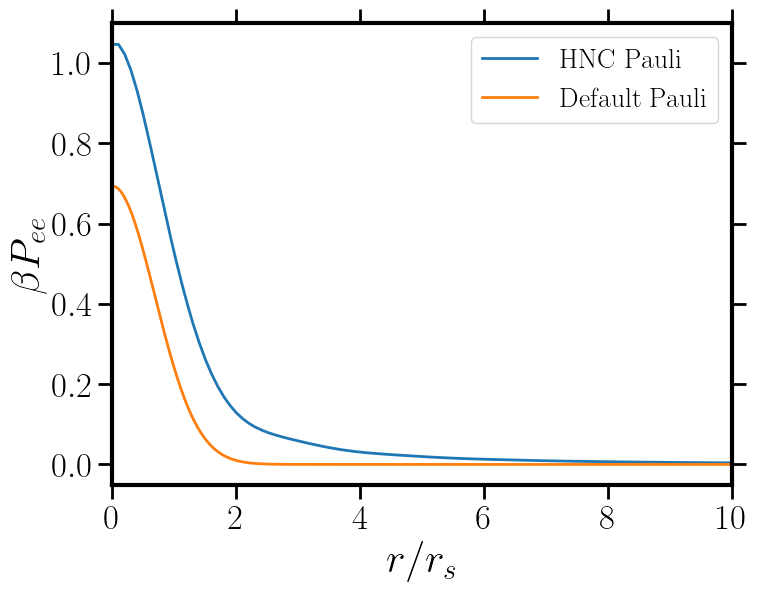

In [8]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

fig, ax = plt.subplots()

ax.plot(jellium.jellium_hnc.r_array, jellium.βP_ee, label='HNC Pauli')
ax.plot(jellium.jellium_hnc.r_array, jellium.qsp.βv_Pauli(  jellium.jellium_hnc.r_array , jellium.qsp.Λee ), label='Default Pauli')

ax.set_xlabel(r"$r/r_s$")
ax.set_ylabel(r"$\beta P_{ee}$")

# ax.set_ylim(0,1.2)
ax.set_xlim(0,10)
ax.legend()

# New Thermodynamics

In [85]:
ε = 1e-4
jellium_1 = jellium_func(Te_eV*(1-ε), ne_cc)
jellium_1.run_jellium_hnc()
jellium_2 = jellium_func(Te_eV*(1+ε), ne_cc)
jellium_2.run_jellium_hnc()
dT = Te_eV*2*ε

d_βP_eV = -Te_eV**2*(jellium_2.βP_ee - jellium_1.βP_ee)/dT
d_βP_AU = d_βP_eV*eV_to_AU
d_β  = -Te_eV**2*( 1/jellium_2.jellium_hnc.Temp_matrix - 1/jellium_1.jellium_hnc.Temp_matrix)[0,0]/dT * eV_to_AU

Te_in_eV: 1.000
Ti_in_eV: 1.000


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:193: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 9.851e-02
Exiting status 0, reverting to best index so far: 35
Final iter:36, Total Error: 9.637e-09
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 9.851e-02
Exiting status 0, reverting to best index so far: 35
Final iter:36, Total Error: 9.637e-09


In [103]:
d_β*jellium.qsp.Te_c/jellium.qsp.Te

0.003269850588862706

# Plot $\beta_c u_P$ vs $\frac{\partial \beta_c u_P}{\partial \beta}$

Missing colon in file '~/plasma/hnc/hnc_paper.mplstyle', line 40 ("text.latex.preamble = r'\\boldmath'")


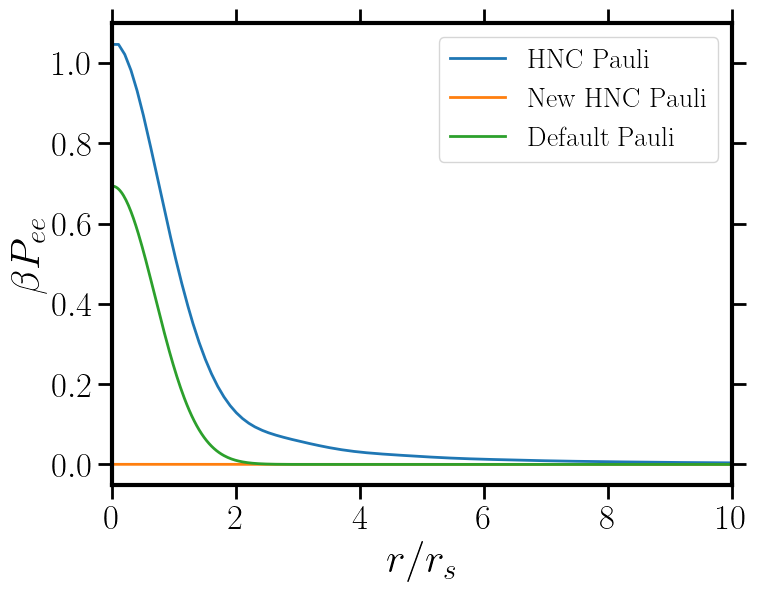

In [86]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

fig, ax = plt.subplots()

ax.plot(jellium.jellium_hnc.r_array, jellium.βP_ee, label='HNC Pauli')
ax.plot(jellium.jellium_hnc.r_array, d_βP_AU, label='New HNC Pauli')

ax.plot(jellium.jellium_hnc.r_array, jellium.qsp.βv_Pauli(  jellium.jellium_hnc.r_array , jellium.qsp.Λee ), label='Default Pauli')

ax.set_xlabel(r"$r/r_s$")
ax.set_ylabel(r"$\beta P_{ee}$")

# ax.set_ylim(0,1.2)
ax.set_xlim(0,10)
ax.legend()

In [100]:
E_ideal_eV_func = lambda Te_eV, Ti_eV: E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ne_AU)*AU_to_eV + 3/2*Ti_eV

def excess_energy_density_matrix(plasma, d_βP ):
    g_matrix = plasma.jellium_hnc.h_r_matrix+1
    rho_matrix = plasma.jellium_hnc.rho[:,np.newaxis]*plasma.jellium_hnc.rho[np.newaxis,:]
    r = plasma.jellium_hnc.r_array[np.newaxis,np.newaxis,:]
    dr = plasma.jellium_hnc.del_r
    
    u_ex_matrix = np.sum(2*π*rho_matrix[:,:,np.newaxis]*d_βP*g_matrix*r**2*dr,axis=2)
    return u_ex_matrix

E_ideal_eV_func(Te_eV, Te_eV), E_hnc_to_eV( excess_energy_density_matrix(jellium, d_βP_AU)[0,0]), E_hnc_to_eV( excess_energy_density_matrix(jellium, jellium.βP_ee)[0,0])

(31.614907197818997, 4.969127656724465, 301.2003255713028)

In [88]:
(3/2*1*jellium.jellium_hnc.Temp_list*AU_to_eV)[0]* np.array([d_β, 1])

array([4.90477588e-03, 3.01149072e+01])

In [93]:
3/2 * jellium.qsp.Te*AU_to_eV

1.5

In [104]:
jellium.qsp.Te_c/jellium.qsp.Te

20.07660479756733